In [1]:
# Version check. Written for Python 3.5.4
import sys
print(sys.version)
# 3.8.5 (default, Sep  4 2020, 02:22:02) 
# [Clang 10.0.0 ]

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
import matplotlib
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sympy import *
from sympy.utilities.autowrap import autowrap
import re
from matplotlib.lines import Line2D


%matplotlib inline

In [3]:
DATE = "20220315"
MNR = "M019"
DESCR = ""

In [4]:
# Define the path to the input folder containing the output parameters
inputFolder_M019_wFeedback = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M019/CDDP/20220314_111222/" 
#inputFolder_M020_woFeedback = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Output/M020/CDDP/20220315_XXXXX/" 

# Define the path to the parameter estimates
fileName_M019_wFeedback = "20220314_111222_MH_M019Model_parameterEstimates_parmset3_cost_80.80.csv" 
#fileName_M020_woFeedback = ".csv" 

# Read in the file with the parameter estimates
file_M019_wFB = inputFolder_M019_wFeedback+fileName_M019_wFeedback
#file_M020_woFB = inputFolder_M020_woFeedback+fileName_M020_woFeedback

outputFolder = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/Notebooks/Figures/"

In [5]:
dataFolder = "/Users/muriel/Documents/LACDR/Projects/PHH/Models/v2_firstRevision/" # Write down the path to the folder that

dataFile = '20201006_MH_CDDPdata_wFUCCI_DDP.csv'

obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']

doseList = [1, 2.5, 5]

plateID_list = [[2, 3, 4],
 [1, 2, 3],
 [1, 2, 3, 4],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3]]

Nt = 43

realDataColName = 'data4modelReal'

interpolDataColName = 'data4modelInterpol'

realTimeColName = 'timeAfterExposure'

timePointsColName = 'timepoints'

Nm = 4

# Read in the data
data = pd.read_csv(dataFolder + dataFile)

# Make a separate dataTemp data frame per cell line, because every cell line can have a different number
# of replicates and save those data frames in a list:
dfListInterpol = []
dfListReal = []
dfListTimeInterpol = []
dfListTimeReal = []
# Loop over the reporters
for cell_linei, celllinet in enumerate(obsStateVarList):
    # Create NrOfDoses matrices with NrOfReplicates rows and NrOfTimepoints columns
    # For example: 22 time points, 3 replicates, 4 reporter cell lines, 5 doses
    dataTempInterpol = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))
    dataTempReal = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))
    dataTempTimeInterpol = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))
    dataTempTimeReal = np.zeros((len(doseList), len(plateID_list[cell_linei]), Nt))

    # Loop over the doses
    for dosei, stresslevel in enumerate(doseList):

        # Loop over the replicates
        for replicatei, replicateID in enumerate(plateID_list[cell_linei]):

            # Loop over the time points
            for tpi in np.arange(0, Nt, 1):
                timeIDinData = tpi + 1
                datasample = data[(data.StateVar == celllinet) & (data.replID == replicateID) &
                                  (data.dose_uMadj == stresslevel) & (data.timeID == timeIDinData)]
                # datasample = data[(data.protein == celllinet) & (data.replID == replicateID) &
                #                   (data.dose_uMadj == stresslevel) & (data.timeID == timeIDinData)]

                dataTempReal[dosei, replicatei, tpi] = datasample[realDataColName]
                dataTempInterpol[dosei, replicatei, tpi] = datasample[interpolDataColName]
                dataTempTimeReal[dosei, replicatei, tpi] = datasample[realTimeColName]
                dataTempTimeInterpol[dosei, replicatei, tpi] = datasample[timePointsColName]
    dfListInterpol.append(dataTempInterpol)
    dfListReal.append(dataTempReal)
    dfListTimeInterpol.append(dataTempTimeInterpol)
    dfListTimeReal.append(dataTempTimeReal)

dfListMeanReal = []
dfListStdReal = []
dfListMean = []
dfListStd = []
dfListTimeMeanReal = []
dfListTimeStdReal = []
dfListTimeMean = []
dfListTimeStd = []
# Loop over the dataframes, i.e. the cell lines
for cell_linei, celllinet in enumerate(obsStateVarList):
    df = dfListInterpol[cell_linei]
    dfReal = dfListReal[cell_linei]
    dfTime = dfListTimeInterpol[cell_linei]
    dfTimeReal = dfListTimeReal[cell_linei]

    dfTemp = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    dfTempReal = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    dfTempTime = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    dfTempTimeReal = np.array([]).reshape(len(plateID_list[cell_linei]), 0)
    for dosei in np.arange(0, len(doseList), 1):
        # Bind the doses horizontally to obtain a NrOfReplicates x (NrOfDoses x NrOfTimepoints) matrix
        dfTemp = np.hstack((dfTemp, df[dosei]))
        dfTempReal = np.hstack((dfTempReal, dfReal[dosei]))
        dfTempTime = np.hstack((dfTempTime, dfTime[dosei]))
        dfTempTimeReal = np.hstack((dfTempTimeReal, dfTimeReal[dosei]))

    # Calculate the mean and std per column, i.e. the mean and std of the replicates
    dfTempM = np.mean(dfTemp, axis=0)
    dfTempS = np.std(dfTemp, axis=0)
    dfTempMReal = np.mean(dfTempReal, axis=0)
    dfTempSReal = np.std(dfTempReal, axis=0)
    dfTempTimeM = np.mean(dfTempTime, axis=0)
    dfTempTimeS = np.std(dfTempTime, axis=0)
    dfTempTimeMReal = np.mean(dfTempTimeReal, axis=0)
    dfTempTimeSReal = np.std(dfTempTimeReal, axis=0)

    # Make a list of the means, where the length of the list is NrOfCelllines
    dfListMean.append(dfTempM)
    dfListStd.append(dfTempS)
    dfListMeanReal.append(dfTempMReal)
    dfListStdReal.append(dfTempSReal)
    dfListTimeMean.append(dfTempTimeM)
    dfListTimeStd.append(dfTempTimeS)
    dfListTimeMeanReal.append(dfTempTimeMReal)
    dfListTimeStdReal.append(dfTempTimeSReal)

# Bind the mean lists as rows to form a matrix with dimensions NrOfCellines x (NrOfDoses x NrOfTimepoints)
dataM = np.vstack(dfListMean)
dataS = np.vstack(dfListStd)
dataMReal = np.vstack(dfListMeanReal)
dataSReal = np.vstack(dfListStdReal)
dataTimeM = np.vstack(dfListTimeMean)
dataTimeS = np.vstack(dfListTimeStd)
dataTimeMReal = np.vstack(dfListTimeMeanReal)
dataTimeSReal = np.vstack(dfListTimeStdReal)

# Transpose the matrices to form a matrix with dimensions (NrOfDoses x NrOfTimepoints) x NrOfCelllines
dataMT = np.transpose(dataM)
dataST = np.transpose(dataS)

# Append all the rows to form a matrix with dimensions 1 x (NrOfCelllines x NrOfDoses x NrOfTimepoints)
dataMTR = dataMT.reshape(Nm * Nt * len(doseList), )
dataSTR = dataST.reshape(Nm * Nt * len(doseList), )

dataNoise = [dataMTR, dataSTR]

# Make an array of the time points as they are dictated by the data
dataTimePoints = data[(data.StateVar == obsStateVarList[0]) & (data.replID == plateID_list[0][0]) &
                      (data.dose_uMadj == doseList[0])][timePointsColName][0:Nt]
realTimePoints = data[(data.StateVar == obsStateVarList[0]) & (data.replID == plateID_list[0][0] ) &
                                      (data.dose_uMadj == doseList[0])][realTimeColName][0:Nt]



In [6]:
# Define ODE model
def p53signaling(z,t,args):
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2rna,MDM2,P21rna,P21,BTG2rna,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_p53rna - kd_p53rna * P53rna
    dP53 = ks_p53 * P53rna + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - kd_p53_mdm2 * MDM2 * P53
    dP53P = k_p * P53 * DD - k_dp * P53P - kd_p53p * P53P - kd_p53p_mdm2 * MDM2 * P53P
    dMDM2rna = ks_mdm2rna + (ks_mdm2_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2rna * MDM2rna
    dMDM2 = ks_mdm2 * MDM2rna - kd_mdm2 * MDM2
    dP21rna = ks_p21rna + (ks_p21_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21rna * P21rna
    dP21 = ks_p21  * P21rna - kd_p21 * P21
    dBTG2rna = ks_btg2rna + (ks_btg2_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2rna * BTG2rna
    dBTG2 = ks_btg2  * BTG2rna - kd_btg2 * BTG2

    # Output
    dzdt = [dDD, dP53rna, dP53, dP53P, dMDM2rna, dMDM2, dP21rna, dP21, dBTG2rna, dBTG2] 

    return dzdt

In [7]:
def mdm2_knockdown(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2rna,MDM2,P21rna,P21,BTG2rna,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_p53rna - kd_p53rna * P53rna
    dP53 = ks_p53 * P53rna + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - kd_p53_mdm2 * MDM2 * P53
    dP53P = k_p * P53 * DD - k_dp * P53P - kd_p53p * P53P - kd_p53p_mdm2 * MDM2 * P53P
    dMDM2rna = 0 # ks_mdm2rna + (ks_mdm2_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2rna * MDM2rna
    dMDM2 = ks_mdm2 * MDM2rna - kd_mdm2 * MDM2
    dP21rna = ks_p21rna + (ks_p21_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21rna * P21rna
    dP21 = ks_p21  * P21rna - kd_p21 * P21
    dBTG2rna = ks_btg2rna + (ks_btg2_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2rna * BTG2rna
    dBTG2 = ks_btg2  * BTG2rna - kd_btg2 * BTG2

    # Output
    dzdt = [dDD, dP53rna, dP53, dP53P, dMDM2rna, dMDM2, dP21rna, dP21, dBTG2rna, dBTG2] 

    return dzdt



In [8]:
def nutlin_20perc(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2rna,MDM2,P21rna,P21,BTG2rna,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_p53rna - kd_p53rna * P53rna
    dP53 = ks_p53 * P53rna + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - 0.2 * kd_p53_mdm2 * MDM2 * P53
    dP53P = k_p * P53 * DD - k_dp * P53P - kd_p53p * P53P - 0.2 * kd_p53p_mdm2 * MDM2 * P53P
    dMDM2rna = ks_mdm2rna + (ks_mdm2_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2rna * MDM2rna
    dMDM2 = ks_mdm2 * MDM2rna - kd_mdm2 * MDM2
    dP21rna = ks_p21rna + (ks_p21_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21rna * P21rna
    dP21 = ks_p21  * P21rna - kd_p21 * P21
    dBTG2rna = ks_btg2rna + (ks_btg2_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2rna * BTG2rna
    dBTG2 = ks_btg2  * BTG2rna - kd_btg2 * BTG2

    # Output
    dzdt = [dDD, dP53rna, dP53, dP53P, dMDM2rna, dMDM2, dP21rna, dP21, dBTG2rna, dBTG2] 

    return dzdt



In [9]:
def nutlin_50perc(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2rna,MDM2,P21rna,P21,BTG2rna,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_p53rna - kd_p53rna * P53rna
    dP53 = ks_p53 * P53rna + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - 0.5 * kd_p53_mdm2 * MDM2 * P53
    dP53P = k_p * P53 * DD - k_dp * P53P - kd_p53p * P53P - 0.5 * kd_p53p_mdm2 * MDM2 * P53P
    dMDM2rna = ks_mdm2rna + (ks_mdm2_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2rna * MDM2rna
    dMDM2 = ks_mdm2 * MDM2rna - kd_mdm2 * MDM2
    dP21rna = ks_p21rna + (ks_p21_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21rna * P21rna
    dP21 = ks_p21  * P21rna - kd_p21 * P21
    dBTG2rna = ks_btg2rna + (ks_btg2_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2rna * BTG2rna
    dBTG2 = ks_btg2  * BTG2rna - kd_btg2 * BTG2

    # Output
    dzdt = [dDD, dP53rna, dP53, dP53P, dMDM2rna, dMDM2, dP21rna, dP21, dBTG2rna, dBTG2] 

    return dzdt




In [10]:
def no_repair(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2rna,MDM2,P21rna,P21,BTG2rna,BTG2 = z
    
    # ODEs
    dDD = ks_dd - 0.2 * kd_dd * DD * P53P + S
    dP53rna = ks_p53rna - kd_p53rna * P53rna
    dP53 = ks_p53 * P53rna + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - kd_p53_mdm2 * MDM2 * P53
    dP53P = k_p * P53 * DD - k_dp * P53P - kd_p53p * P53P - kd_p53p_mdm2 * MDM2 * P53P
    dMDM2rna = ks_mdm2rna + (ks_mdm2_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2rna * MDM2rna
    dMDM2 = ks_mdm2 * MDM2rna - kd_mdm2 * MDM2
    dP21rna = ks_p21rna + (ks_p21_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21rna * P21rna
    dP21 = ks_p21  * P21rna - kd_p21 * P21
    dBTG2rna = ks_btg2rna + (ks_btg2_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2rna * BTG2rna
    dBTG2 = ks_btg2  * BTG2rna - kd_btg2 * BTG2

    # Output
    dzdt = [dDD, dP53rna, dP53, dP53P, dMDM2rna, dMDM2, dP21rna, dP21, dBTG2rna, dBTG2] 

    return dzdt



In [11]:
# Stress level decrease
def sFunction(s_init,r,t):
    out = s_init * np.exp(-r*t)
    return out

In [12]:
def facetplot(solList, varnames, title = "Model"):
    nrows = len(varnames)
    ncols = len(solList)
    fig, ax = plt.subplots(nrows,ncols,sharex=True, sharey='row')

    for i,sol in enumerate(solList):
        for row in range(0,nrows):
            ax[row,i].plot(t,sol[:,row], color = "#000000")
    
    for row in range(0,nrows):
        ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
        ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)


    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    fig.suptitle(title, fontsize = 18)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=16)
    plt.ylabel("Intensity (a.u.)", fontsize=16)

In [13]:
def facetplot_addP53(solList, varnames, varnames_total, title = "Model"):
    nrows = len(varnames_total)
    ncols = len(solList)
    
    p53_ids = []
    for i,vn in enumerate(varnames):
        if vn == "p53" or vn == "p53p":
            p53_ids.append(i)
    
    fig, ax = plt.subplots(nrows,ncols,sharex=True, sharey='row')

    for i,sol in enumerate(solList):
        for row in range(0,p53_ids[0]):
            ax[row,i].plot(t,sol[:,row], color = "#000000")
            
        ax[p53_ids[0],i].plot(t,sol[:,p53_ids[0]] + sol[:,p53_ids[1]], color = "#000000")
        
        for row in range(p53_ids[1],nrows):
            ax[row,i].plot(t,sol[:,row+1], color = "#000000")
    
    for row in range(0,nrows):
        ax[row,ncols-1].set_ylabel(varnames_total[row], rotation = -90, fontsize = 12)
        ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)


    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    fig.suptitle(title, fontsize = 18)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=16)
    plt.ylabel("Intensity (a.u.)", fontsize=16)

In [14]:
def plot(dzdt, t, header):
    
    figureSize = (5,4)
    #tick_locs = np.arange(min(t), max(t)+1, 12*60)
    #tick_labels = tick_locs/60
    
    t = [i * 1 for i in t]
    
    f1 = plt.figure(figsize = figureSize)
    plt.plot(t,dzdt[:,7], "--", label = 'early G1', color = "k", alpha = 0.2,linewidth=3)
    plt.plot(t,dzdt[:,8], "--", label = 'G0', color = "grey", alpha = 0.2,linewidth=3)
    plt.plot(t,dzdt[:,7]+dzdt[:,8], label = 'G0 & early G1', color = "grey",linewidth=3)
    plt.plot(t,dzdt[:,9], label = 'G1', color = "r",linewidth=3)
    plt.plot(t,dzdt[:,10], label = 'G1/S', color = "y",linewidth=3)
    plt.plot(t,dzdt[:,11], label = 'S & G2', color = "g",linewidth=3)
    #plt.plot(t,dzdt[:,1]+dzdt[:,2]+dzdt[:,3]+dzdt[:,4]+dzdt[:,5], "--", label = 'N', color = "k")
    plt.xlabel('Time (h)', fontsize=22)
    plt.ylabel('Number of cells', fontsize=22)
    plt.legend(fontsize=12)
    plt.xlim(0,(t)[-1]+5)
    plt.title(header, fontsize=24)
    #plt.xticks(tick_locs,tick_labels)
    plt.ylim(0,12)
    plt.show()
    #f.savefig("Plots/atr.pdf", bbox_inches='tight')

    f3 = plt.figure(figsize = figureSize)
    plt.plot(t,dzdt[:,6], label = 'Space', color = "b")
    plt.xlabel('Time (h)', fontsize=18)
    plt.ylabel('Intensity', fontsize=18)
    plt.legend(fontsize=12)
    plt.xlim(0,(t)[-1]+5)
    #plt.xticks(tick_locs,tick_labels)
    plt.ylim(0,1.1)
    plt.show()
    #f.savefig("Plots/atr.pdf", bbox_inches='tight')

In [15]:
def facetplot_1col(sol, varnames, plot_title,color, title = "",
                    file = "Fig1"):
    nrows = len(varnames)
    fig, ax = plt.subplots(nrows,1,sharex=True, sharey='row')
    
    for row in range(0,nrows):
        ax[row].plot(t*1.5,sol[:,row], color = color, linewidth = 4)
        ax[row].tick_params(axis = 'both', labelsize=16)
        ax[row].locator_params(axis='y', nbins=4)
                
    for row in range(0,nrows):
        ax[row].set_ylabel(varnames[row], rotation = -90, fontsize = 22)
        ax[row].yaxis.set_label_coords(1.03,0.5)
    
    ax[0].set_title(plot_title,fontdict={'fontsize': 28}, pad=20)
    
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(16)
    fig.set_figwidth(3.5)
    if not title == "":
        fig.suptitle(title, fontsize = 24)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=28, labelpad=16)
    plt.ylabel("Simulated intensity (a.u.)", fontsize=28, labelpad=28)
    
    #fig.savefig(outputFolder + file + ".pdf", bbox_inches='tight')
    
    

In [16]:
def facetplotAdj(solList, varnames, plot_titles,colors, title = "",
            file = "Fig1"):
    nrows = len(varnames)
    ncols = len(solList)
    fig, ax = plt.subplots(nrows,ncols,sharex=True, sharey='row')
    
    for i,sol in enumerate(solList):
        for row in range(0,nrows):
            ax[row,i].plot(t*1.5,sol[:,row], color = colors[i], linewidth = 4)
            ax[row,i].tick_params(axis = 'both', labelsize=16)
            ax[row,i].locator_params(axis='y', nbins=5)
                
    for row in range(0,nrows):
        ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 22)
        ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)
    
    for j,pt in enumerate(plot_titles):
        ax[0, j].set_title(pt,
                           fontdict={'fontsize': 22}, pad=20)
    
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(16)
    fig.set_figwidth(6)
    if not title == "":
        fig.suptitle(title, fontsize = 24, y = 0.95)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=28, labelpad=16)
    plt.ylabel("Simulated intensity (a.u.)", fontsize=28, labelpad=30)
    
    #fig.savefig(outputFolder + file + ".pdf", bbox_inches='tight')
    
    

[0.0, 0.0, 7.028912330376679e-17, -6.938893903907228e-18, 0.0, 0.0, 3.469446951953614e-18, 0.0, 0.0, 0.0]


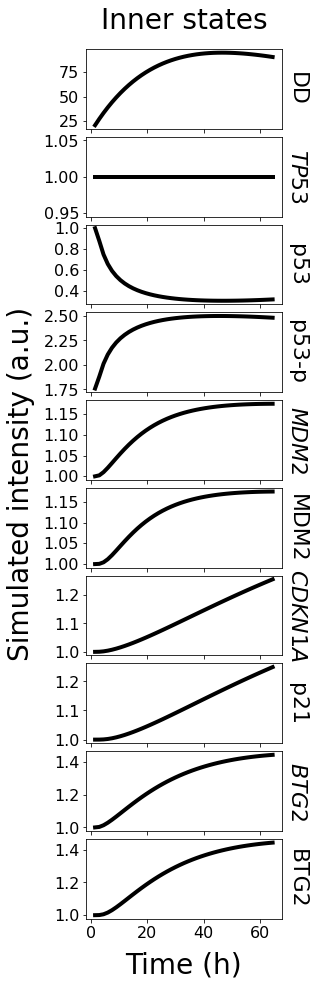

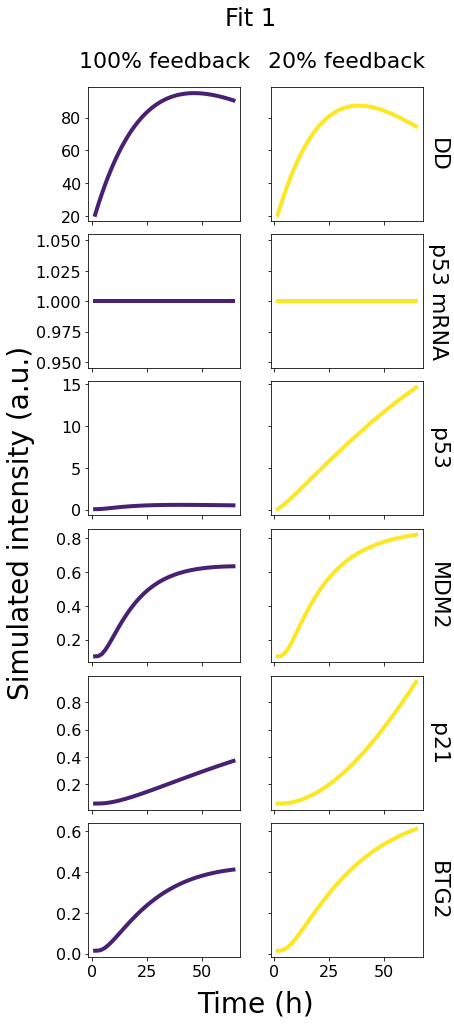

In [17]:
### Run M019 ###

MNR = "M019"

# Define the parameters
parameterEst = pd.read_csv(file_M019_wFB)

pAllNew = parameterEst["est_value"].values

# Make the parameters global variables
for i in parameterEst.iterrows():
    sText = str(parameterEst.iloc[i[0], 0]) + " = " + str(parameterEst.iloc[i[0], 2])
    #print(sText)
    exec(sText)
    
EC1 = 1
kd_p53rna = 1
P53rna_init = 1
MDM2rna_init = 1
P21rna_init = 1
BTG2rna_init = 1
P53_init = 1
MDM2_init = 1
P21_init = 1
BTG2_init = 1
kd_btg2 = 1
kd_p21 = 1
kd_mdm2 = 1

# Check steady states
# ODEs
dDD = ks_dd - kd_dd * DD_init * P53P_init
dP53rna = ks_p53rna - kd_p53rna * P53rna_init
dP53 = ks_p53 * P53rna_init + k_dp * P53P_init - k_p * P53_init * DD_init - kd_p53 * P53_init - kd_p53_mdm2 * MDM2_init * P53_init
dP53P = k_p * P53_init * DD_init - k_dp * P53P_init - kd_p53p * P53P_init - kd_p53p_mdm2 * MDM2_init * P53P_init
dMDM2rna = ks_mdm2rna + (ks_mdm2_p53p * P53P_init**4) / (Km_mdm2**4 + P53P_init**4) - kd_mdm2rna * MDM2rna_init
dMDM2 = ks_mdm2 * MDM2rna_init - kd_mdm2 * MDM2_init
dP21rna = ks_p21rna + (ks_p21_p53p * P53P_init**4) / (Km_p21**4 + P53P_init**4) - kd_p21rna * P21rna_init
dP21 = ks_p21  * P21rna_init - kd_p21 * P21_init
dBTG2rna = ks_btg2rna + (ks_btg2_p53p * P53P_init**4) / (Km_btg2**4 + P53P_init**4) - kd_btg2rna * BTG2rna_init
dBTG2 = ks_btg2  * BTG2rna_init - kd_btg2 * BTG2_init

# Output
steady_state = [dDD, dP53rna, dP53, dP53P, dMDM2rna, dMDM2, dP21rna, dP21, dBTG2rna, dBTG2]
print(steady_state)

# initial condition
z = [DD_init,P53rna_init,P53_init,P53P_init,MDM2rna_init,MDM2_init,P21rna_init,P21_init,BTG2rna_init,BTG2_init]

# time points
t = np.linspace(1,43,43)

# solve ODE
dzdt_Control = odeint(p53signaling,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC3],))

facetplot_1col(sol = dzdt_Cisplatin3, 
               varnames = ["DD","$TP53$","p53","p53-p","$MDM2$","MDM2","$CDKN1A$","p21","$BTG2$","BTG2"],
               plot_title = "Inner states",
              color = "black",
              file = "M019_simulation")

# facetplot_addP53([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
#                  ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
#                  ["DD","P53rna","p53 total","MDM2","p21","BTG2"],
#                  title = MNR + " simulation")

### MDM2 knockdown
# Define ODE model
MDM2_kd = 0

# initial condition
z = [DD_init,P53rna_init,P53_init,P53P_init,MDM2rna_init,MDM2_init,P21rna_init,P21_init,BTG2rna_init,BTG2_init]

# solve ODE
dzdt_Control_KD = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1_KD = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2_KD = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3_KD = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,EC3],))

# facetplot_addP53([dzdt_Control_KD,dzdt_Cisplatin1_KD,dzdt_Cisplatin2_KD,dzdt_Cisplatin3_KD], 
#                  ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
#                  ["DD","P53rna","p53 total","MDM2","p21","BTG2"],
#                  title = MNR + " MDM2 knock-out")

### MDM2 with Nutlin 20%

# initial condition
z = [DD_init,P53rna_init,P53_init,P53P_init,MDM2rna_init,MDM2_init,P21rna_init,P21_init,BTG2rna_init,BTG2_init]

# solve ODE
dzdt_Control_KD20 = odeint(nutlin_20perc,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1_KD20 = odeint(nutlin_20perc,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2_KD20 = odeint(nutlin_20perc,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3_KD20 = odeint(nutlin_20perc,z,t, args = ([sFunction,tau1,EC3],))

### MDM2 with Nutlin 50%

# initial condition
z = [DD_init,P53rna_init,P53_init,P53P_init,MDM2rna_init,MDM2_init,P21rna_init,P21_init,BTG2rna_init,BTG2_init]

# solve ODE
dzdt_Control_KD50 = odeint(nutlin_50perc,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1_KD50 = odeint(nutlin_50perc,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2_KD50 = odeint(nutlin_50perc,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3_KD50 = odeint(nutlin_50perc,z,t, args = ([sFunction,tau1,EC3],))

# facetplot_addP53([dzdt_Control_KD2,dzdt_Cisplatin1_KD2,dzdt_Cisplatin2_KD2,dzdt_Cisplatin3_KD2], 
#                  ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
#                  ["DD","P53rna","p53 total","MDM2","p21","BTG2"],
#                  title = MNR + " Nutlin simulation")

### Limited repair

# initial condition
z = [DD_init,P53rna_init,P53_init,P53P_init,MDM2rna_init,MDM2_init,P21rna_init,P21_init,BTG2rna_init,BTG2_init]


# solve ODE
dzdt_Control_nr = odeint(no_repair,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1_nr = odeint(no_repair,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2_nr = odeint(no_repair,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3_nr = odeint(no_repair,z,t, args = ([sFunction,tau1,EC3],))

# facetplot_addP53([dzdt_Control_nr,dzdt_Cisplatin1_nr,dzdt_Cisplatin2_nr,dzdt_Cisplatin3_nr], 
#                  ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
#                  ["DD","P53rna","p53 total","MDM2","p21","BTG2"],
#                  title = MNR + " less repair")


scaled_Control = np.vstack((dzdt_Control[::,0],
                            dzdt_Control[::,1], 
                            sf_p53 * (dzdt_Control[::,2] + dzdt_Control[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control[::,9] + offset_btg2)).T

scaled_Cisplatin3 = np.vstack((dzdt_Cisplatin3[::,0],
                            dzdt_Cisplatin3[::,1], 
                            sf_p53 * (dzdt_Cisplatin3[::,2] + dzdt_Cisplatin3[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3[::,9] + offset_btg2)).T

scaled_Control_KD20 = np.vstack((dzdt_Control_KD20[::,0],
                            dzdt_Control_KD20[::,1], 
                            sf_p53 * (dzdt_Control_KD20[::,2] + dzdt_Control_KD20[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control_KD20[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control_KD20[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control_KD20[::,9] + offset_btg2)).T

scaled_Cisplatin3_KD20 = np.vstack((dzdt_Cisplatin3_KD20[::,0],
                            dzdt_Cisplatin3_KD20[::,1], 
                            sf_p53 * (dzdt_Cisplatin3_KD20[::,2] + dzdt_Cisplatin3_KD20[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3_KD20[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3_KD20[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3_KD20[::,9] + offset_btg2)).T

scaled_Control_KD50 = np.vstack((dzdt_Control_KD50[::,0],
                            dzdt_Control_KD50[::,1], 
                            sf_p53 * (dzdt_Control_KD50[::,2] + dzdt_Control_KD50[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control_KD50[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control_KD50[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control_KD50[::,9] + offset_btg2)).T

scaled_Cisplatin3_KD50 = np.vstack((dzdt_Cisplatin3_KD50[::,0],
                            dzdt_Cisplatin3_KD50[::,1], 
                            sf_p53 * (dzdt_Cisplatin3_KD50[::,2] + dzdt_Cisplatin3_KD50[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3_KD50[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3_KD50[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3_KD50[::,9] + offset_btg2)).T


scaled_Control_nr = np.vstack((dzdt_Control_nr[::,0],
                            dzdt_Control_nr[::,1], 
                            sf_p53 * (dzdt_Control_nr[::,2] + dzdt_Control_nr[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control_nr[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control_nr[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control_nr[::,9] + offset_btg2)).T

scaled_Cisplatin3_nr = np.vstack((dzdt_Cisplatin3_nr[::,0],
                            dzdt_Cisplatin3_nr[::,1], 
                            sf_p53 * (dzdt_Cisplatin3_nr[::,2] + dzdt_Cisplatin3_nr[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3_nr[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3_nr[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3_nr[::,9] + offset_btg2)).T


viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,10)

facetplotAdj([scaled_Cisplatin3,scaled_Cisplatin3_KD20], 
              ["DD","p53 mRNA","p53","MDM2","p21","BTG2"],
              plot_titles = ["100% feedback","20% feedback"], 
             title = "Fit 1",
             colors = [viridis(reps[1]),viridis(reps[9])],
            file = "Nutlin_effect_wFB")


In [18]:
def facetplotWide(solList, varnames, legend_titles,colors, title = "",
            file = "Fig1", w = 10, h = 10):
    nrows = len(varnames)
    ncols = 1#len(solList)
    fig, ax = plt.subplots(nrows,ncols,sharex=True, sharey='row')
    
    for i,sol in enumerate(solList):
        for row in range(0,nrows):
            if i > 0:
                ax[row].plot(t*1.5,sol[:,row], color = colors[i], linewidth = 4, dashes=[3,2])
            else:
                ax[row].plot(t*1.5,sol[:,row], color = colors[i], linewidth = 4)                
            ax[row].tick_params(axis = 'both', labelsize=16)
            ax[row].locator_params(axis='y', nbins=5)
                
    for row in range(0,nrows):
        ax[row].set_ylabel(varnames[row], rotation = -90, fontsize = 22)
        ax[row].yaxis.set_label_coords(1.03,0.5)
    
#     for j,pt in enumerate(plot_titles):
#         ax[0].set_title(pt,
#                            fontdict={'fontsize': 22}, pad=20)
    
    # Legend
    custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                    Line2D([0], [0], color=colors[1], lw=4, dashes=[3,2]),
                    Line2D([0], [0], color=colors[2], lw=4, dashes=[3,2])]
    
    # add a big axes, hide frame
    fig.legend(custom_lines, (legend_titles), 
          fontsize = 15, loc = "upper right", borderaxespad=0.1, ncol = 3)
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(h)
    fig.set_figwidth(w)
    if not title == "":
        fig.suptitle(title, fontsize = 24, y = 0.95)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=28, labelpad=16)
    plt.ylabel("Simulated intensity (a.u.)", fontsize=28, labelpad=30)
    
    fig.savefig(outputFolder + file + ".pdf", bbox_inches='tight')
    
    

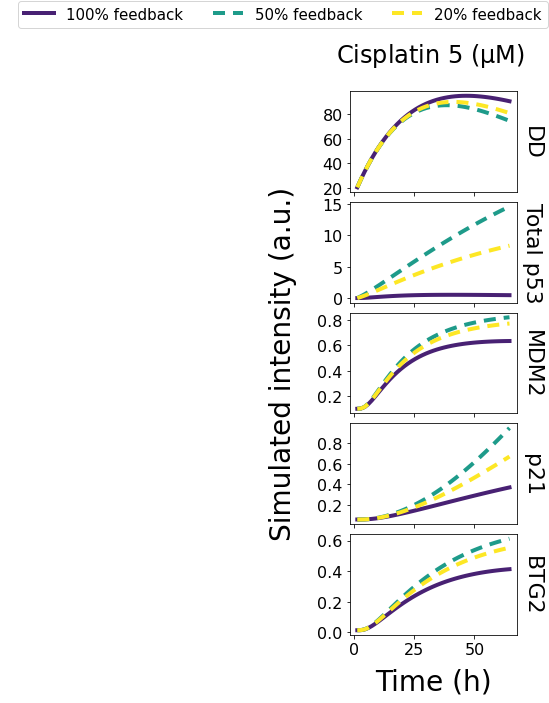

In [23]:
scaled_Cisplatin3 = np.vstack((dzdt_Cisplatin3[::,0],
                            sf_p53 * (dzdt_Cisplatin3[::,2] + dzdt_Cisplatin3[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3[::,9] + offset_btg2)).T

scaled_Cisplatin3_KD20 = np.vstack((dzdt_Cisplatin3_KD20[::,0],
                            sf_p53 * (dzdt_Cisplatin3_KD20[::,2] + dzdt_Cisplatin3_KD20[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3_KD20[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3_KD20[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3_KD20[::,9] + offset_btg2)).T

scaled_Cisplatin3_KD50 = np.vstack((dzdt_Cisplatin3_KD50[::,0],
                            sf_p53 * (dzdt_Cisplatin3_KD50[::,2] + dzdt_Cisplatin3_KD50[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3_KD50[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3_KD50[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3_KD50[::,9] + offset_btg2)).T


scaled_Cisplatin3_nr = np.vstack((dzdt_Cisplatin3_nr[::,0],
                            sf_p53 * (dzdt_Cisplatin3_nr[::,2] + dzdt_Cisplatin3_nr[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Cisplatin3_nr[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Cisplatin3_nr[::,7] + offset_p21,
                            sf_btg2 * dzdt_Cisplatin3_nr[::,9] + offset_btg2)).T



viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,10)

facetplotWide([scaled_Cisplatin3,scaled_Cisplatin3_KD20, scaled_Cisplatin3_KD50], 
              ["DD","Total p53","MDM2","p21","BTG2"],
              legend_titles = ["100% feedback","50% feedback","20% feedback"], 
             title = "Cisplatin 5 (${\mathrm{\mu}}$M)",
             colors = [viridis(reps[1]),viridis(reps[5]),viridis(reps[9])],
            file = "Fig4A_Nutlin_repair_effect_M019_Cisplatin", w = 3)

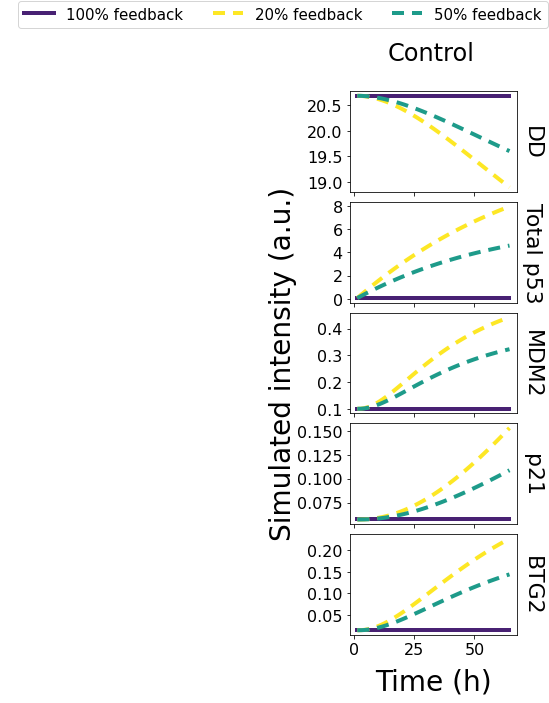

In [21]:
scaled_Control = np.vstack((dzdt_Control[::,0],
                            sf_p53 * (dzdt_Control[::,2] + dzdt_Control[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control[::,9] + offset_btg2)).T

scaled_Control_KD20 = np.vstack((dzdt_Control_KD20[::,0],
                            sf_p53 * (dzdt_Control_KD20[::,2] + dzdt_Control_KD20[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control_KD20[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control_KD20[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control_KD20[::,9] + offset_btg2)).T

scaled_Control_KD50 = np.vstack((dzdt_Control_KD50[::,0],
                            sf_p53 * (dzdt_Control_KD50[::,2] + dzdt_Control_KD50[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control_KD50[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control_KD50[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control_KD50[::,9] + offset_btg2)).T

scaled_Control_nr = np.vstack((dzdt_Control_nr[::,0],
                            sf_p53 * (dzdt_Control_nr[::,2] + dzdt_Control_nr[::,3]) + offset_p53,
                            sf_mdm2 * dzdt_Control_nr[::,5] + offset_mdm2,
                            sf_p21 * dzdt_Control_nr[::,7] + offset_p21,
                            sf_btg2 * dzdt_Control_nr[::,9] + offset_btg2)).T

viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,10)

facetplotWide([scaled_Control,scaled_Control_KD20, scaled_Control_KD50], 
              ["DD","Total p53","MDM2","p21","BTG2"],
              legend_titles = ["100% feedback","20% feedback","50% feedback"], 
             title = "Control",
             colors = [viridis(reps[1]),viridis(reps[9]),viridis(reps[5])],
            file = "Fig4A_Nutlin_repair_effect_M019_Control", w = 3)